# Prevendo Notas do ENEM

O objetivo dessa análise é desenvolver um modelo que seja capaz de prever a nota no ENEM de um participante, baseado em dados socioeconômicos sobre ele.
<br><br>
O objetivo é que, a partir dessas previsões, a gente consiga analisar quais variáveis possuem maior impacto na previsão, o que pode ajudar a avaliar a necessidade do sistema de cotas.
<br><br>
Iremos julgar como injustiça um parâmetro que supostamente não deveria ser relevante para decidir a nota do participante, mas que o modelo julgou como relevante.

## Baixando dados

Os dados originais do ENEM 2022 já foram tratados para o modelo nos arquivos de tratamento.
<br><br>
Agora, os datasets de microdados e hábitos de estudo serão juntados, usando o código de inscrição dos participantes.

In [42]:
# Bibliotecas importantes
import pandas as pd
import numpy as np
import seaborn as sns

In [43]:
df_microdados = pd.read_csv("microdados_tratado.csv")
df_estudo = pd.read_csv("habitos_estudo_tratado.csv")

In [44]:
# Tamanho dos datasets originais
print(f"Tamanho Microdados: {len(df_microdados)}")
print(f"Tamanho Hábitos Estudo: {len(df_estudo)}")

Tamanho Microdados: 669781
Tamanho Hábitos Estudo: 78241


In [45]:
# Juntando datasets
df = pd.merge(df_microdados, df_estudo, on="NU_INSCRICAO")
df

,NU_INSCRICAO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESCOLA,TP_ENSINO,Q006,COR_RACA_1.0,COR_RACA_2.0,COR_RACA_3.0,COR_RACA_4.0,...,PANDEMIA_GESTAO,PANDEMIA_PRATICAS,GESTAO,PRATICAS,Q025,Q026,Q028,Q030,Q032,Q033
0,210056012033,3,0,1.0,0.0,5,True,False,False,False,...,2.25,1.583333,1.0,1.0,2,2,4,2,2,2
1,210057478691,3,0,1.0,0.0,1,False,False,True,False,...,1.50,1.500000,0.0,0.5,2,2,6,2,2,2
2,210056688095,4,1,1.0,0.0,2,False,True,False,False,...,1.00,1.000000,1.0,1.0,2,1,1,1,1,1
3,210057511905,3,0,1.0,0.0,1,False,False,True,False,...,1.25,1.583333,2.0,2.0,1,1,1,1,1,1
4,210057838909,3,0,1.0,0.0,2,False,False,True,False,...,1.00,1.166667,1.0,1.0,2,2,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21818,210057405995,3,1,0.0,0.0,5,False,False,True,False,...,1.75,2.166667,1.5,3.0,2,1,1,2,2,2
21819,210055900340,2,1,0.0,0.0,9,False,False,True,False,...,1.75,1.250000,1.0,1.5,2,2,2,2,2,2
21820,210054991409,3,1,1.0,0.0,4,True,False,False,False,...,1.00,1.000000,0.0,0.0,2,2,2,1,2,2
21821,210055081282,6,1,1.0,0.0,2,False,False,True,False,...,0.00,0.000000,0.0,0.0,2,2,2,2,1,1


In [46]:
# Quantas linhas sobrariam se removessemos NAs?
df.dropna().shape[0]

21823

In [47]:
# Quanto é esse valor, em porcentagem, em relaçao ao dataset original do ENEM 2022?
# Se for ver nos outros arquivos, o número total de candidatos é 3.476.105
TAMANHO_TOTAL = 3476105
tamanho_novo  = df.dropna().shape[0]
100 * tamanho_novo / TAMANHO_TOTAL

0.6278003685159108

In [48]:
# Retirando o NU_INSCRICAO, pois foi usado somente para juntar os datasets
df.drop("NU_INSCRICAO", axis=1, inplace=True)

Juntando os datasets, temos apenas 0,63% dos dados originais do ENEM 2022. Isso significa que a amostra que estamos lidando é de 0,63% da população total (onde a população são os participantes do ENEM 2022). Embora seja um valor relativamente baixo, ainda é possível fazer boas análises, contanto que essa amostra seja representativa. 

## Train/Test Split

<Axes: xlabel='NOTA_FINAL', ylabel='Count'>

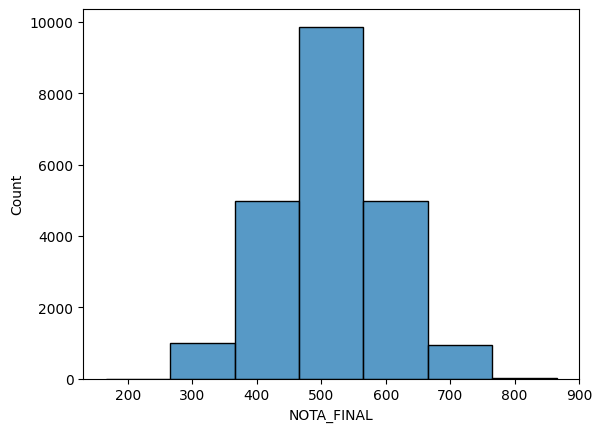

In [49]:
# Proporção das notas
import seaborn as sns
sns.histplot(x=df["NOTA_FINAL"], binwidth=100)

In [50]:
# Para garantir que os datasets de treino e teste sigam essa proporção, é interessante criar um parâmetro auxiliar
# O parâmetro irá controlar em qual faixa a nota se encontra (0-100, 100-200, ...)
from math import floor
faixa = 100
auxiliar = np.floor(df["NOTA_FINAL"] / faixa).astype(int)
auxiliar

0        7
1        4
2        5
3        3
4        4
        ..
21818    6
21819    5
21820    4
21821    3
21822    5
Name: NOTA_FINAL, Length: 21823, dtype: int64

In [51]:
# Fazendo split de treino/teste
# Random state fixado para constância de resultados
from sklearn.model_selection import train_test_split
X = df.drop("NOTA_FINAL", axis=1)
Y = df["NOTA_FINAL"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=auxiliar, random_state=42)

<Axes: xlabel='NOTA_FINAL', ylabel='Count'>

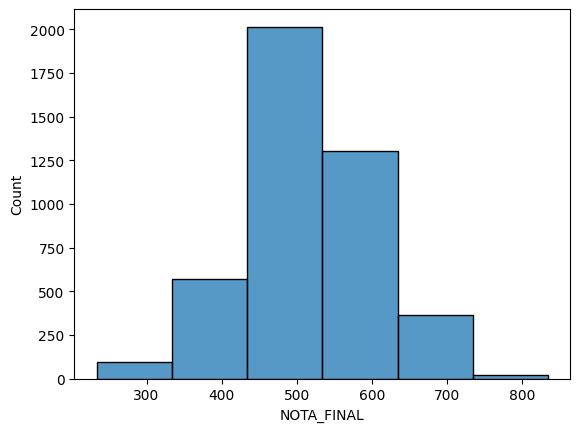

In [52]:
# Teste
import seaborn as sns
sns.histplot(x=y_test, binwidth=100)

<Axes: xlabel='NOTA_FINAL', ylabel='Count'>

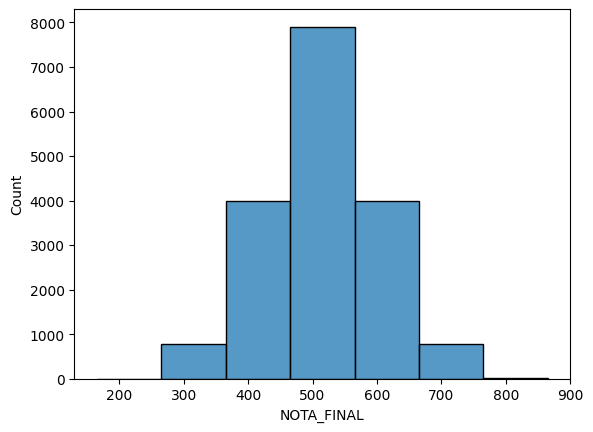

In [53]:
# Treino
import seaborn as sns
sns.histplot(x=y_train, binwidth=100)

## Testando modelos básicos

Nessa sessão, serão treinados três modelos, sem muita alteração nos seus hiperparâmetros, para ter uma noção dos resultados que podemos conseguir. Foram escolhidos os seguintes modelos: Linear Regression, Random Forest e SVM.

In [54]:
# Para avaliar os modelos, será usado k-fold
from sklearn.model_selection import cross_val_score

In [55]:
# Regressão Linear
from sklearn.linear_model import LinearRegression
model_linearreg = LinearRegression()
cross_val_score(model_linearreg, X_train, y_train, cv=5, scoring="r2").mean()

0.30188873054211346

In [56]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
model_randforest = RandomForestRegressor(n_jobs=-1)
cross_val_score(model_randforest, X_train, y_train, cv=5, scoring="r2").mean()

0.28637732608648586

In [57]:
# SVM
from sklearn.svm import SVR
model_svr = SVR()
cross_val_score(model_svr, X_train, y_train, cv=5, scoring="r2").mean()

0.28015785464799425

Os três modelos tiveram um R2 parecido e consideravelmente baixo (em torno de 30%), o que indica que as variáveis que temos a disposição não são suficientes para prever com precisão as notas dos participantes do ENEM.
<br><br>
Por terem tido resultados parecidos e pelo modelo de SVM ter um treinamento lento, ele será desconsiderado no restante da análise.

### Variáveis Relevantes

O modelo de RandomForest possui alta interpretabilidade, o que ajuda a entender como as variáveis impactam na previsão da nota do estudante.

In [61]:
model_randforest.fit(X_train, y_train)
features = sorted(zip(model_randforest.feature_importances_, X_train.columns), reverse=True)
for importance, feature in features:
    print(f"{feature}: {importance}")

Q028: 0.1445795590683151
PANDEMIA_PRATICAS: 0.10251180123645781
Q006: 0.09274246348649334
TP_ESCOLA: 0.07980942449983015
PANDEMIA_GESTAO: 0.07457750525910165
GESTAO: 0.05565932096519955
PRATICAS: 0.04642288558123933
TP_FAIXA_ETARIA: 0.04413396939593953
Q034: 0.04004107423508934
Q003: 0.030897158425886206
Q004: 0.02982044383137347
Q001: 0.022893200739705202
TP_SEXO: 0.020747645943120886
Q033: 0.01970096753833679
Q030: 0.01951437307609407
Q032: 0.018619641893385885
Q025: 0.018565245541505702
Q026: 0.017664019412712135
COR_RACA_1.0: 0.01578462918786604
REGIAO_NORDESTE: 0.015335968240150846
REGIAO_SUDESTE: 0.014900121944005452
COR_RACA_3.0: 0.012525769703944468
REGIAO_NORTE: 0.010779790524065311
REGIAO_CENTROOESTE: 0.010423159626356948
COR_RACA_2.0: 0.009033235685512581
REGIAO_SUL: 0.008899904926827198
Q002: 0.008711475574710881
COR_RACA_4.0: 0.004319969503625365
NACIONALIDADE_1.0: 0.003305390447634558
NACIONALIDADE_2.0: 0.002739311485343876
TP_ENSINO: 0.002294658809885253
COR_RACA_5.0: 0.

In [63]:
# Mostrando apenas as mais relevantes (que estão acima da média)
media = 1 / len(X.columns)
for importance, feature in features:
    if importance > media:
        print(f"{feature}: {importance}")

Q028: 0.1445795590683151
PANDEMIA_PRATICAS: 0.10251180123645781
Q006: 0.09274246348649334
TP_ESCOLA: 0.07980942449983015
PANDEMIA_GESTAO: 0.07457750525910165
GESTAO: 0.05565932096519955
PRATICAS: 0.04642288558123933
TP_FAIXA_ETARIA: 0.04413396939593953
Q034: 0.04004107423508934
Q003: 0.030897158425886206
Q004: 0.02982044383137347


A Questão 28 dos Hábitos de Estudo trata sobre problemas enfrentados na pandemia (sem tempo de descanso, pouca atividade física, dificuldade de se concentrar, ...), e as Práticas na Pandemia trata sobre como o aluno estudou durante a pandemia e com que frequência.
<br><br>
O tipo de escola que o aluno estudou (se era pública ou não) e sua faixa salarial também parecem ter grandes impactos no desempenho do estudante no ENEM.
<br><br>
A maneira como o aluno fez a gestão dos seus estudos, tanto na pandemia quanto no geral, também são relevantes, bem como suas práticas de estudo no geral.
<br><br>
A idade do estudante parece ter grande impacto também. Isso é plausível, já que pessoas mais velhas tendem a ir melhor, por terem mais experiência com a prova de anos anteriores e por terem mais maturidade no geral.
<br><br>
A questão 34 fala sobre a avaliação do aluno sobre si próprio (o quanto ele se julga preparado para a prova). Embora essa autoavaliação parece ser relevante, não é tão relevante quantos outras variáveis.
<br><br>
Por fim, as Questões 3 e 4 dos Hábitos de Estudo também falam sobre o estudo do aluno na pandemia (mais especificamente, sobre o modelo de ensino e a evolução do aprendizado, respectivamente).
<br><br>
Das 11 variáveis com relevância acima da média, 5 falavam especificamente sobre a pandemia, 8 falavam sobre sobre o estudo do aluno e 2 falavam sobre a situação socioeconômica do estudante (sendo essas duas a terceira e a quarta variáveis mais relevantes).
<br><br><br>
Essa análise inicial indica que a pandemia pode ter tido uma grande influência nas notas dos estudantes.


## Melhorando Modelo de Random Forest

### Hiperparâmetros

Visando buscar um modelo melhor, será feito uma análise de hiperparâmetros do modelo de Random Forest.
<br><br>
A técnica utilizada aqui será o Grid Search.

In [64]:
# Profundidade máxima das árvores no modelo base
max([estimator.tree_.max_depth for estimator in model_randforest.estimators_])

46

In [67]:
# Escolha dos hiperparâmetros a serem testados
# Será variado o número de árvores e a profundidade delas
param_grid = [
    {"n_estimators": [10, 100, 250, 500], "max_depth": [2, 20, 40]}
]

In [68]:
from sklearn.model_selection import GridSearchCV
model_randforest = RandomForestRegressor(n_jobs=-1)
grid_search = GridSearchCV(model_randforest, param_grid=param_grid, cv=5, scoring="r2", return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid=[{'max_depth': [2, 20, 40],
                          'n_estimators': [10, 100, 250, 500]}],
             return_train_score=True, scoring='r2')

In [69]:
# All scores (sorted)
cvres = grid_search.cv_results_
results = sorted(zip(cvres["mean_test_score"], cvres["params"]), reverse=True)
for score, params in results:
    print(score, params)

0.29564198095476096 {'max_depth': 20, 'n_estimators': 500}
0.29413470797070473 {'max_depth': 20, 'n_estimators': 250}
0.29167167587777526 {'max_depth': 40, 'n_estimators': 500}
0.29148167663250046 {'max_depth': 20, 'n_estimators': 100}
0.2898841182329859 {'max_depth': 40, 'n_estimators': 250}
0.2873972489686665 {'max_depth': 40, 'n_estimators': 100}
0.2328206020506567 {'max_depth': 20, 'n_estimators': 10}
0.21581059740364825 {'max_depth': 40, 'n_estimators': 10}
0.2046895914963094 {'max_depth': 2, 'n_estimators': 500}
0.204649863650571 {'max_depth': 2, 'n_estimators': 250}
0.20452658905691173 {'max_depth': 2, 'n_estimators': 100}
0.203354840999044 {'max_depth': 2, 'n_estimators': 10}


Note que houve pouca diferença entre os scores de cada modelo, o que significa que alterar os hiperparâmetros não leva a grande melhora no modelo nesse problema. Isso indica que ou o modelo de Random Forest não modela bem o problema, ou as variáveis que temos não são suficientes para criar boas previsões.

In [70]:
# Analisando os parâmetros mais importantes no melhor modelo obtido
features = sorted(zip(grid_search.best_estimator_.feature_importances_, X_train.columns), reverse=True)
media = 1 / len(X.columns)
for importance, feature in features:
    if importance > media:
        print(f"{feature}: {importance}")

Q028: 0.1516067376105937
PANDEMIA_PRATICAS: 0.09907089825365954
Q006: 0.09444013509201798
TP_ESCOLA: 0.08597073452637974
PANDEMIA_GESTAO: 0.07382428995197426
GESTAO: 0.05324260962157561
PRATICAS: 0.04531327148718926
TP_FAIXA_ETARIA: 0.04403743198251721
Q034: 0.03972681012593156
Q003: 0.032179336766637916


Houve pouca diferença nas variáveis julgadas relevantes entre o melhor modelo da Grid Search e o modelo básico.

### Features mais relevantes

Agora será avaliado se é possível melhorar o modelo limitando as variáveis utilizadas.

In [71]:
# Usando variáveis mais relevantes do melhor modelo
best_hiperparameters = grid_search.best_params_
best_features = []
media = 1 / len(X.columns)
for importance, feature in features:
    if importance > media:
        best_features.append(feature)
best_features

['Q028',
 'PANDEMIA_PRATICAS',
 'Q006',
 'TP_ESCOLA',
 'PANDEMIA_GESTAO',
 'GESTAO',
 'PRATICAS',
 'TP_FAIXA_ETARIA',
 'Q034',
 'Q003']

In [72]:
best_model = RandomForestRegressor(n_jobs=-1, n_estimators=best_hiperparameters["n_estimators"], max_depth=best_hiperparameters["max_depth"])
X_temp = X_train[best_features]
cross_val_score(best_model, X_temp, y_train, cv=5, scoring="r2").mean()

0.230333293627333

Claramente, limitar as variáveis utilizadas não ajuda a melhorar a previsão do modelo.